In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.experiments import *

import matplotlib.pyplot as plt
from matplotlib import colors


/home/users/delon/.local/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


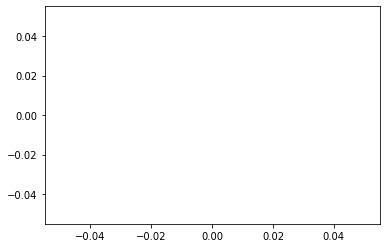

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1
})

e_order = ['CHIME',
          'HETDEX',
          'COMAP',
           'CCAT-prime',
           'SPHEREx',
]

In [3]:
ell_idxs = [0, 37, 62, 73, 99]
titles = [10, 100, 500, 1000, 5000]

plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2


In [4]:
#preload I_I and IHiIHi
dict_II = {}
dict_IHiIHi = {}

for e_idx, e in enumerate(e_order):
    n_bins = 100
    if(e == 'SPHEREx'):
        n_bins = 15
    print(e_idx, e)
    zmin = experiments[e]['zmin']
    zmax = experiments[e]['zmax']
    line_str = experiments[e]['line_str']
    
    Omega_field  =  np.array(experiments[e]['Omega_field'].to(u.rad**2)) #rad^2
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

    chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
    chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
    dchi_binned = np.mean(np.diff(chi_bin_edges))
    
    
    def get_binned(base, n_external = 300):
        external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)

        oup = np.zeros((100, n_bins, n_bins), dtype=np.float64)
        for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
                idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
                idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
                oup[:,i,j] = (np.sum(base[:,
                                          idx1[0]:idx1[-1]+1,
                                          idx2[0]:idx2[-1]+1], 
                                     axis=(1, 2)) / len(idx1) / len(idx2))
        return oup

    #get <II>

    I_I_unbinned = np.load('/oak/stanford/orgs/kipac/users/delon/SCRATCH_LIMxCMBL_2025_05_26/I_auto/'+
                              'I_auto_n_ext_%d_zmin_%.1f_zmax_%.1f.npy'%(3000, 
                                                                         zmin, 
                                                                         zmax))

    I_I = get_binned(I_I_unbinned, n_external = 3000)
    dict_II[e] = I_I
    
    
    IHiIHi_oup_fname = '/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/LIM_auto/'
    IHiIHi_oup_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_jax_qmc.npy'%(line_str,
                                                                                   zmin, zmax, 
                                                                                   24, 
                                                                                   n_bins)

    IHiIHi = np.load(IHiIHi_oup_fname)

    for ell_idx in range(len(ells)):
        #Cheng and Higham, 1998
        eigenvalues, eigenvectors = np.linalg.eig(IHiIHi[ell_idx])
        patched_eigenvalues = np.where(eigenvalues <0, 0.0, eigenvalues)
        IHiIHi[ell_idx] = eigenvectors @ np.diag(patched_eigenvalues) @ eigenvectors.T
    dict_IHiIHi[e] = IHiIHi

0 CHIME
1 HETDEX
2 COMAP
3 CCAT-prime
4 SPHEREx


In [5]:
import numpy as np

def covariance_to_correlation(covariance_matrix):
    variances = np.diag(covariance_matrix)
    if np.any(variances < 0):
        raise ValueError("negative variances")
    std_devs = np.sqrt(variances)
    
    inv_std_devs = 1 / std_devs
    D_inv = np.diag(inv_std_devs)
    correlation_matrix = D_inv @ covariance_matrix @ D_inv
    np.fill_diagonal(correlation_matrix, 1.0)
    
    return correlation_matrix

In [6]:
_alphas = {
    'CHIME': 150,
    'HETDEX': 400,
    'COMAP': 250,
    'SPHEREx': 250,
    'CCAT-prime': 500,
}

In [7]:
tilde_chi = np.arange(0, 2, 0.001)

def plot_gap(alpha, 
             beta,
             text,
             ax,
            gap_size = 180):
    
    if(alpha >= 1000):
        gap_size = 200
    tilde_chi_prime = beta + tilde_chi

    if np.all(tilde_chi_prime > 1):
        return
    idxs = np.where(tilde_chi_prime <= 1)

    mid_idx = len(tilde_chi[idxs]) // 2
    mid_x = tilde_chi[idxs][mid_idx]
    mid_y = tilde_chi_prime[idxs][mid_idx]
    if((mid_x <= 0.1 or mid_x >= 0.9)):
        return


    ax.plot(tilde_chi[idxs][:mid_idx-gap_size//2], 
            tilde_chi_prime[idxs][:mid_idx-gap_size//2], 
            ls='-',
            c='k', lw=0.25)

    ax.plot(tilde_chi[idxs][mid_idx+gap_size//2:], 
            tilde_chi_prime[idxs][mid_idx+gap_size//2:], 
            ls='-',
            c='k', lw=0.25)


    ax.text(mid_x, mid_y, text, 
            ha='center', va='center', rotation=45, fontsize= 3.8)



/tmp/ipykernel_192824/3335962169.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad = 0.0)


0 CHIME
1 HETDEX
2 COMAP
3 CCAT-prime
4 SPHEREx
0 CHIME
1 HETDEX
2 COMAP
3 CCAT-prime
4 SPHEREx
0 CHIME
1 HETDEX
2 COMAP
3 CCAT-prime
4 SPHEREx
0 CHIME
1 HETDEX
2 COMAP
3 CCAT-prime
4 SPHEREx
0 CHIME
1 HETDEX
2 COMAP
3 CCAT-prime
4 SPHEREx


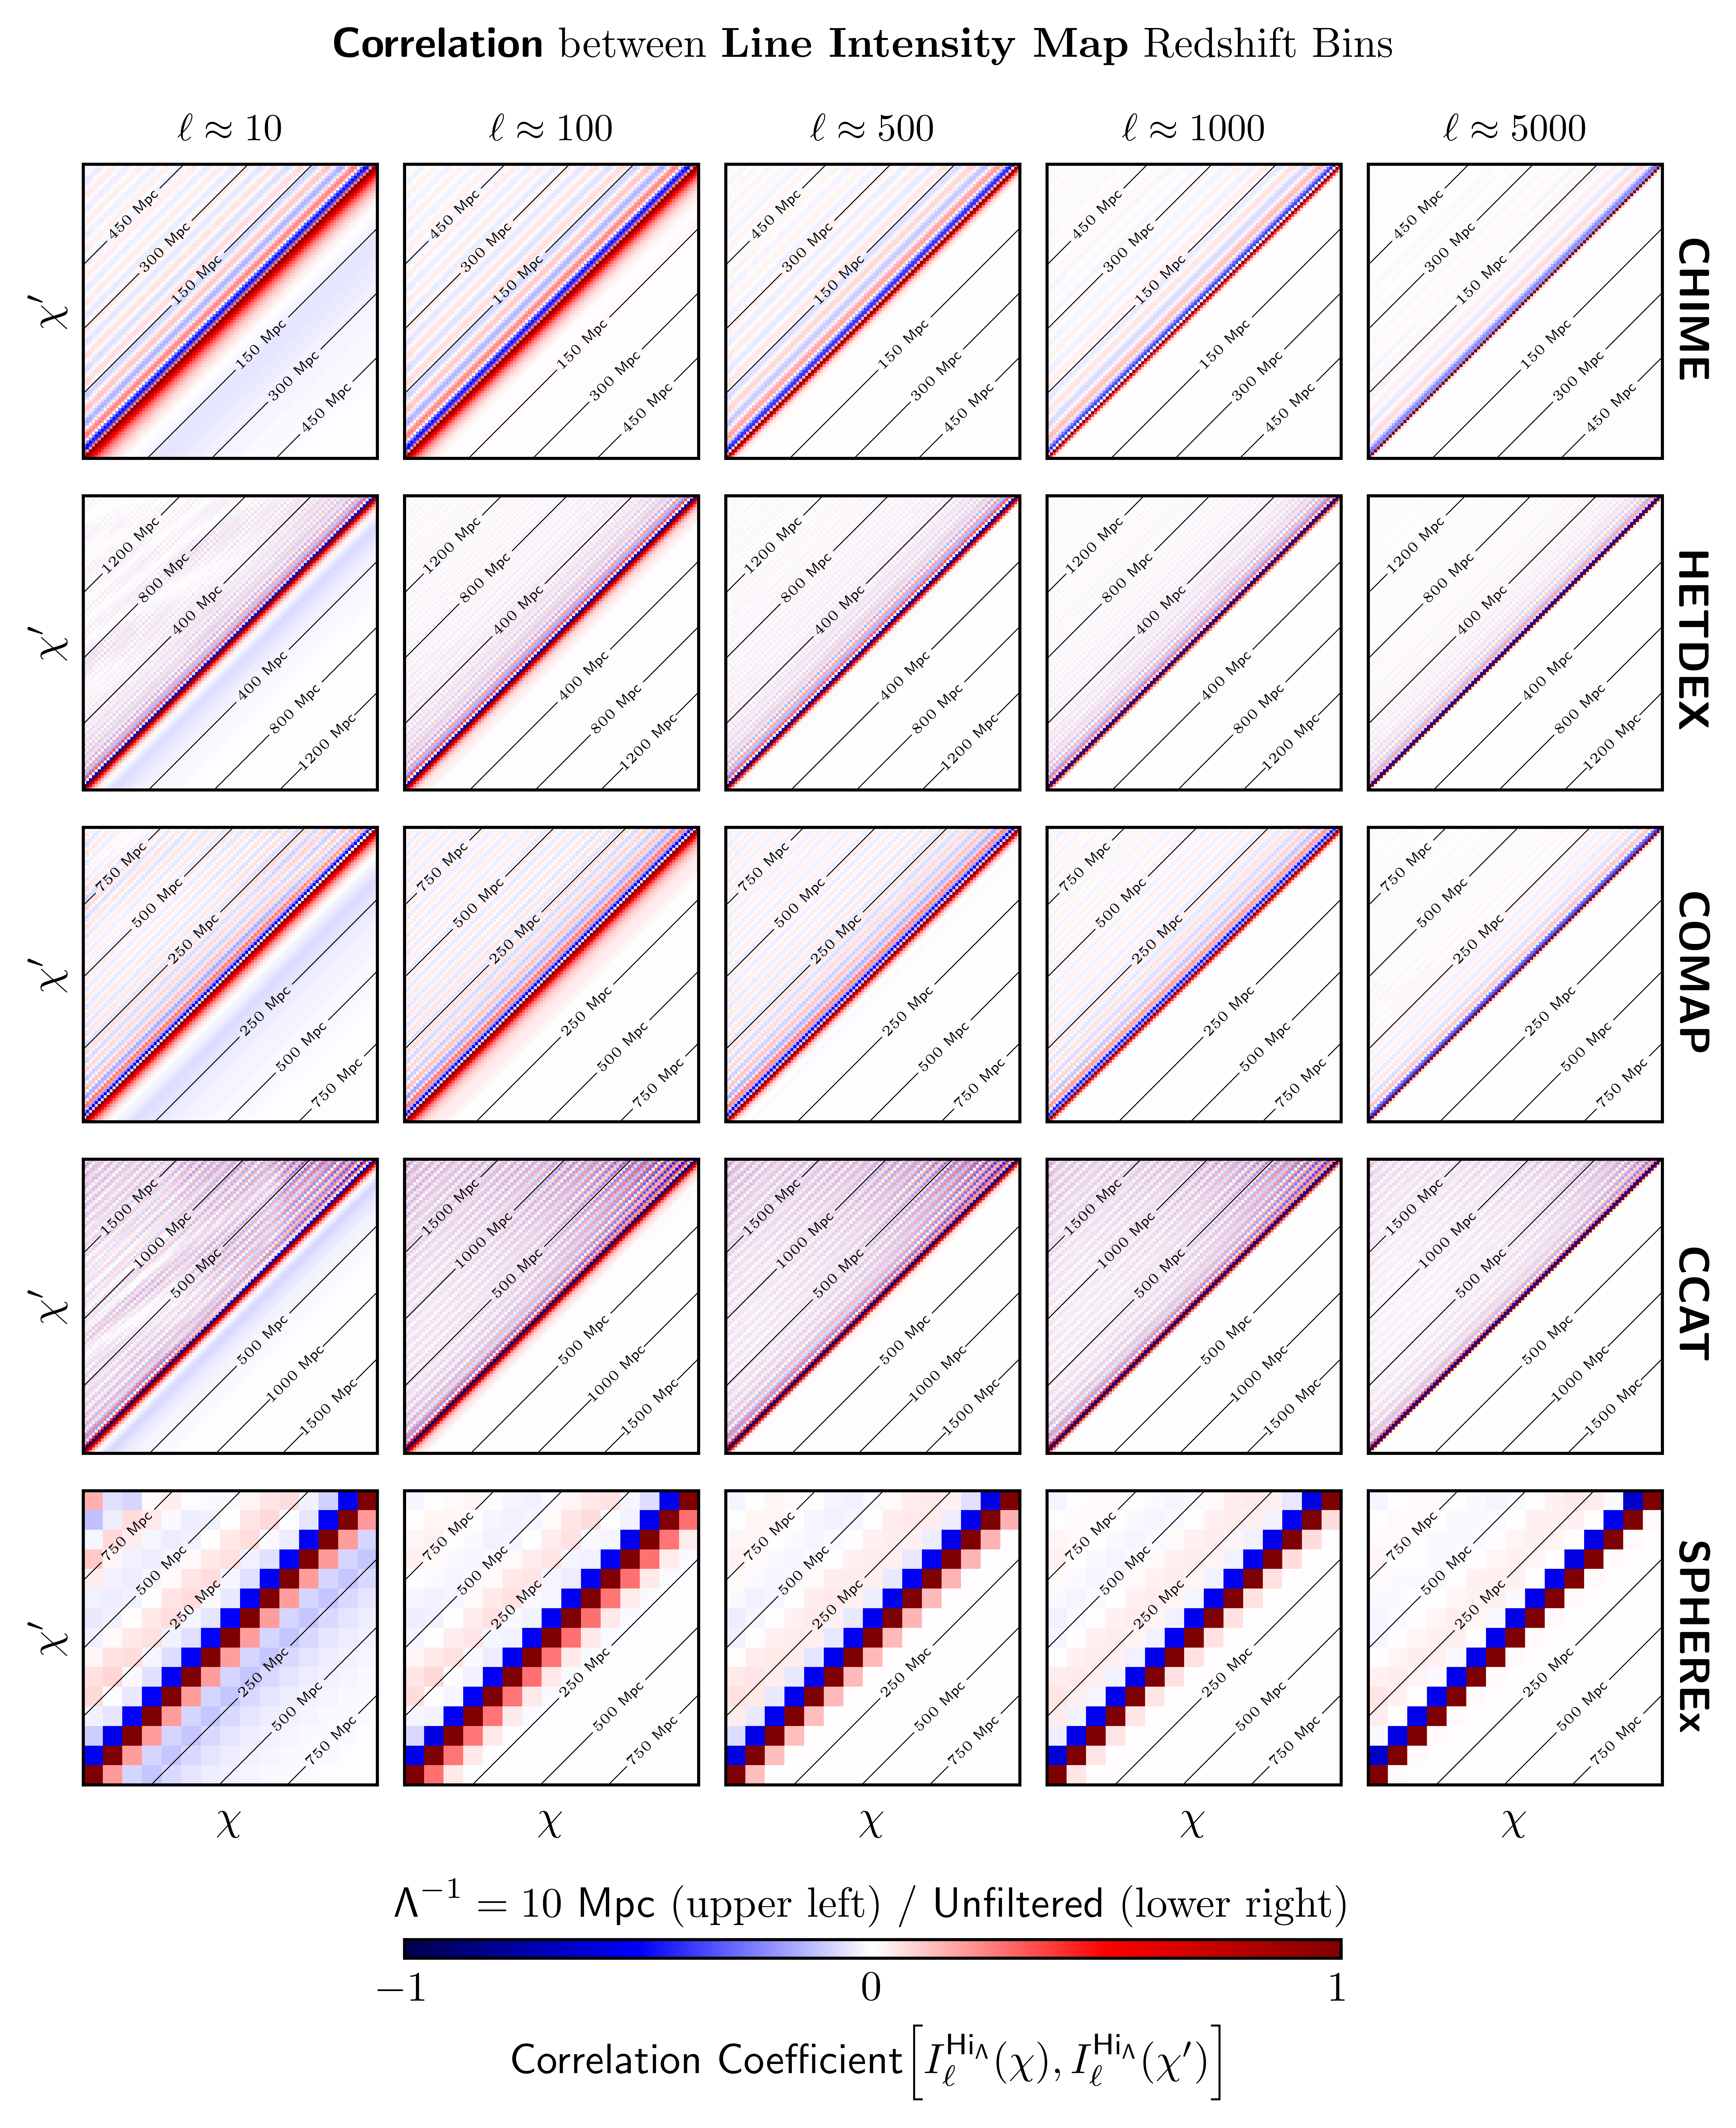

In [8]:
fig, _axs = plt.subplots(nrows=5, ncols=5, 
                             figsize = (6.0, 3.65/3 * 5 ), facecolor = 'none', dpi = 1000,
                        sharex=True,sharey=True)
plt.tight_layout(pad = 0.0)

_axs = _axs.T

for l_idx in range(len(ell_idxs)):
    for e_idx in range(len(e_order)):
    
        e = e_order[e_idx]
        n_bins = 100
        if(e == 'SPHEREx'):
            n_bins = 15
        print(e_idx, e)
        
        axs = _axs[:, e_idx]
        ax = axs[l_idx]

        _axs[l_idx, 0].set_title(r'$\ell \approx %d$'%(titles[l_idx]), fontsize = 10)
        zmin = experiments[e]['zmin']
        zmax = experiments[e]['zmax']
        line_str = experiments[e]['line_str']

        Omega_field  =  np.array(experiments[e]['Omega_field'].to(u.rad**2)) #rad^2
        chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
        chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

    #     extent = np.array([chimin, chimax,
    #                        chimin, chimax])
    #     extent /= 1000 # Mpc -> Gpc

        extent = [0,1,0,1]

        I_I = dict_II[e]    
        IHiIHi = dict_IHiIHi[e]

        ax = axs[l_idx]
        ell_idx = ell_idxs[l_idx]
        
        
#         #plot II as usual
        _I_I = covariance_to_correlation(I_I[ell_idx])
        ax.imshow(_I_I, 
                  vmin = -1,
                  vmax=1,
                  cmap='seismic',
                 extent=extent,
                 interpolation = 'none',
                 origin = 'lower')
        
        
        #plot IHiIHi other half
        _IHiIHi = covariance_to_correlation(IHiIHi[ell_idx])
        _IHiIHi = _IHiIHi * np.tri(*_IHiIHi.shape)
        _IHiIHi[np.where(_IHiIHi == 0)] = None

        im = ax.imshow(_IHiIHi,
                       vmin = -1,
                       vmax=1,
                       cmap = 'seismic',
                       extent=extent,
                       interpolation = 'none',
                       origin = 'lower')        
        
        
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if(e_idx == 4):
            ax.set_xlabel(r'$\chi$')
            
        if(l_idx == 0):
            ax.set_ylabel(r"$\chi'$")
            

        #plot distance measures
        for i in range(5):
            alpha = (i+1)*_alphas[e] #Mpc
            plot_gap(alpha=alpha,beta=alpha/(chimax-chimin), text = r'%d \textsf{Mpc}'%(np.abs(alpha)), ax=ax)
            plot_gap(alpha=-alpha,beta=-alpha/(chimax-chimin), text = r'%d \textsf{Mpc}'%(np.abs(alpha)), ax=ax)
            
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        
_axs = _axs.T
for l_idx in range(len(ell_idxs)):
    _e_txt = e_order[l_idx]
    if(_e_txt == 'CCAT-prime'):
        _e_txt = 'CCAT'
    _axs[l_idx, -1].text(1.03, 0.5, r'\textsf{\textbf{%s}}'%(_e_txt),
                             transform=_axs[l_idx, -1].transAxes, 
                             ha='left', va='center',
                             rotation=-90)

#     _axs[l_idx, -1].text(1.03, 0.5, r'$\ell \approx %d$'%(titles[l_idx]),
#                              transform=_axs[l_idx, -1].transAxes, 
#                              ha='left', va='center',
#                              rotation=-90)

    
    
# #key

_bbox_bottom_right = _axs[-1,-1].get_position()
_bbox_2 = _axs[-2,-1].get_position()
_bbox_3 = _axs[-1,-2].get_position()

dy_btwn_box = _bbox_2.ymin - _bbox_bottom_right.ymax 
dx_btwn_box = _bbox_bottom_right.xmin - _bbox_3.xmax

dy_box = _bbox_bottom_right.ymax - _bbox_bottom_right.ymin
dx_box = _bbox_bottom_right.xmax - _bbox_bottom_right.xmin


# key_ax = fig.add_axes([_bbox_bottom_right.xmin, 
#                         _bbox_bottom_right.ymin - 2*dy_btwn_box - dy_box,
#                         dx_box, 
#                         dy_box,])  # [left, bottom, width, height]
# key_ax.tick_params(axis='both', which='both', direction='out')
# key_ax.set_xlim(0,1)
# key_ax.set_ylim(0,1)
# key_ax.set_xticks([0,1], labels = [r'$\chi_{\rm min}$', r'$\chi_{\rm max}$'], rotation=90)
# key_ax.set_yticks([0,1], labels = [r'$\chi_{\rm min}$', r'$\chi_{\rm max}$'])

# plot_gap(0.0,0.0, text = r"$\chi=\chi'$", ax=key_ax, gap_size=150)
# plot_gap(0.0,0.5, text = r"{\sf Constant} $\chi'-\chi$", ax=key_ax, gap_size=320)
# plot_gap(0.0,-0.5, text = r"{\sf Constant} $\chi-\chi'$", ax=key_ax, gap_size=320)


# offset = .15
# key_ax.text(0.5 - offset, 0.5 + offset, 
#     r"$\Lambda^{-1}=10$ {\sf Mpc}",
#     ha='center', va='center', fontsize=8, rotation=45)

# key_ax.text(0.5 + offset, 0.5 - offset, 
#     r"\textsf{Unfiltered}",
#     ha='center', va='center', fontsize=8, rotation=45)

# key_ax.fill_between(tilde_chi, tilde_chi, np.ones_like(tilde_chi), 
#                     color = 'yellow', lw=0)
# key_ax.fill_between(tilde_chi, tilde_chi, np.zeros_like(tilde_chi), 
#                     color = 'cyan', lw=0)

# key_ax.text(1.03, 0.5, r'\textbf{\textsf{Legend}}',
#                              transform=key_ax.transAxes, 
#                              ha='left', va='center',
#                              rotation=-90)

#cbar
_bbox = _axs[-1,1].get_position()


cbar_ax = fig.add_axes([_bbox.xmin, 
                        _bbox_bottom_right.ymin - 2*dy_btwn_box - dy_box/3,
                        (3*dx_box+2*dx_btwn_box), 
                        dy_box/16,],
                      facecolor='none')  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax,
                   orientation='horizontal', )
cbar.ax.tick_params(labelsize=11,  direction='out', length=0)
cbar.ax.set_xticks([-1,0,1])

cbar.ax.set_xlabel(r"\textsf{Correlation Coefficient}$\left[I^{\sf Hi_\Lambda}_\ell(\chi), I^{\sf Hi_\Lambda}_\ell(\chi')\right]$", fontsize = 11)
cbar.ax.set_title(r'${\sf \Lambda}^{-1}=10$ {\sf Mpc} (upper left) / \textsf{Unfiltered} (lower right)',
                 fontsize=11)
fig.text(plt_cntr, 1.05, r"\textsf{\textbf{Correlation}} between \textbf{Line Intensity Map} Redshift Bins",
         ha='center', 
         va='bottom', 
        fontsize=11)

plt.savefig('figures/013.002.pdf', bbox_inches='tight')